In [11]:
import squidpy as sq
import scanpy as sc
import numpy as np
import torch
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.preprocessing import normalize
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix
from MPNNModel import MPNNModel
from InvariantGNN import InvariantGNN
from EquivariantGNN import EquivariantGNN
import random
from sklearn.utils.class_weight import compute_class_weight
import json
import matplotlib.pyplot as plt
from scipy.sparse import hstack


In [2]:
def save_results(filename, results):
    with open(filename, 'w') as f:
        for result in results:
            json.dump(result, f)
            f.write("\n")


In [3]:
adata = sq.datasets.seqfish()

labels = adata.obs['celltype_mapped_refined'].cat.codes.values
classes = np.unique(labels)
_, counts = np.unique(labels, return_counts=True)
class_weights = torch.tensor(compute_class_weight(class_weight='balanced', classes=classes, y=labels), dtype=torch.float32)

X_with_spatial = hstack((adata.X, adata.obsm['spatial']))

normalized_x = normalize(adata.X, norm='max', axis=0)
log_x = adata.X.copy()
log_x.data = np.log(log_x.data)
normalized_log_x = normalize(log_x, norm='max', axis=0)


In [55]:
def plot_feature(feature_index):
    for X in [adata.X, log_x, normalized_x, normalized_log_x]:
        x = np.asarray(X[feature_index]
                       [X[feature_index] > 0]).reshape(-1)
        plt.hist(x, bins=20)
        plt.show()


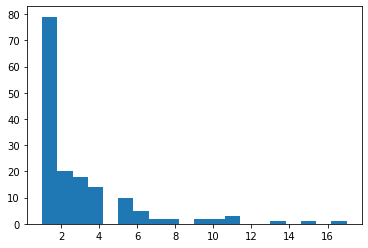

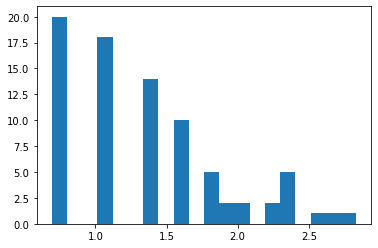

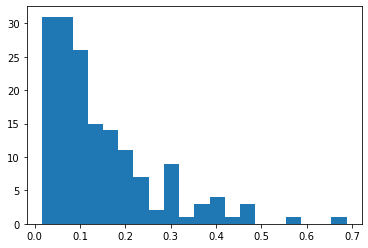

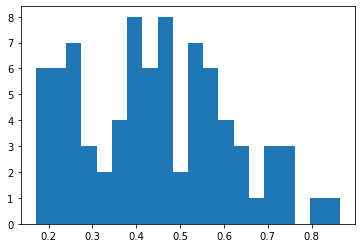

In [58]:
plot_feature(0)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

if 'spatial_distances' not in adata.obsp:
    sq.gr.spatial_neighbors(adata, n_neighs=6, coord_type='generic')

In [5]:
def evaluate(y_true, y_pred):
    return {
        'accuracy_score': metrics.accuracy_score(y_true, y_pred),
        'balanced_accuracy': metrics.balanced_accuracy_score(y_true, y_pred),
        'f1_score': metrics.f1_score(y_true, y_pred, average='macro', labels=classes, zero_division=0, ),
        'recall': metrics.recall_score(y_true, y_pred, average='macro', labels=classes, zero_division=0),
        'precision_score': metrics.precision_score(y_true, y_pred, average='macro', labels=classes, zero_division=0),
    }

def average_stats(stats_list):
    keys = stats_list[0].keys()
    n = len(stats_list)
    avg = {}
    for key in keys:
        sum = 0
        for stats in stats_list:
            sum += stats[key]
        avg[key] = sum / n
    return avg


def train_eval_k_fold(model, data, class_weights=None, n_splits=3):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
    stats_list = []
    patience = 4
    patience_counter = 0
    max_epochs = 100
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1604)
    for train_index, test_index in skf.split(data.x, labels):
        random.shuffle(train_index)
        val_size = int(0.2 * len(train_index))
        val_index = train_index[-val_size:]
        train_index = train_index[:-val_size]
        stats = None
        model.reset_parameters()
        best_score = np.Inf
        old_val_loss = np.Inf
        for epoch in range(max_epochs):
            model.train()
            optimizer.zero_grad()
            out = model(data)
            loss = F.cross_entropy(out[train_index], data.y[train_index], weight=class_weights)
            loss.backward()
            optimizer.step()
            model.eval()
            predictions = torch.argmax(out, dim=1)
            val_loss = F.cross_entropy(
                out[val_index], data.y[val_index], weight=class_weights)
            if val_loss >= old_val_loss:
                patience_counter += 1
                if patience_counter == patience:
                    break
            else:
                patience_counter = 0
                if val_loss < best_score:
                    best_score = val_loss
                    stats = evaluate(
                        labels[test_index], predictions[test_index])
                    stats['epochs'] = epoch
            old_val_loss = val_loss
        if not stats:
            stats = evaluate(labels[test_index],
                             predictions[test_index])
            stats['epochs'] = epoch
        stats_list.append(stats)
    avg_stats = average_stats(stats_list)
    return avg_stats


In [6]:
# Build the graph for the GNN models
def get_graph_data(X) -> Data:
    edge_index, edge_attr = from_scipy_sparse_matrix(
        adata.obsp['spatial_distances'])
    edge_attr = edge_attr.view(-1, 1).float()
    x_index, x_values = from_scipy_sparse_matrix(X)
    x = torch.sparse_coo_tensor(x_index, x_values)
    y = torch.tensor(labels, dtype=torch.long)
    pos = torch.tensor(adata.obsm['spatial'], dtype=torch.float32)
    data = Data(edge_index=edge_index, edge_attr=edge_attr, x=x, y=y, pos=pos)
    data = data.to(device)
    return data


In [8]:
data = get_graph_data(adata.X)
invariant_results = []
equivariant_results = []
mpnn_results = []
nums_layers = [2,3,4,5]
hidden_dims = [128, 256, 512]
for num_layers in nums_layers:
    for hidden_dim in hidden_dims:
        description = f"{num_layers} layers, hidden dim = {hidden_dim}"
        equvariant_model = EquivariantGNN(num_layers=num_layers, in_dim=adata.X.shape[1], 
                                          emb_dim=hidden_dim, out_dim=len(classes), edge_dim=0, pos_aggr='mean')
        invariant_model = InvariantGNN(num_layers=num_layers, in_dim=adata.X.shape[1],
                                          emb_dim=hidden_dim, out_dim=len(classes), edge_dim=1)
        mpnn_model = MPNNModel(num_layers=num_layers, in_dim=adata.X.shape[1],
                               emb_dim=hidden_dim, out_dim=len(classes), edge_dim=0)
        equivariant_results.append(train_eval_k_fold(equvariant_model, data))
        invariant_results.append(train_eval_k_fold(invariant_model, data))
        mpnn_results.append(train_eval_k_fold(mpnn_model, data))
        equivariant_results[-1]['descriptions'] = description
        invariant_results[-1]['descriptions'] = description
        mpnn_results[-1]['description'] = description


In [9]:
save_results("equivariant_results", equivariant_results)
save_results("invariant_results", invariant_results)

In [14]:
model = EquivariantGNN(num_layers=3, in_dim=adata.X.shape[1],
                       emb_dim=128, out_dim=len(classes), edge_dim=1, pos_aggr='mean')


In [15]:
feature_treatment_results = []
# explore data normalization
for X in [adata.X, log_x, normalized_x, normalized_log_x]:
    data = get_graph_data(X)
    feature_treatment_results.append(train_eval_k_fold(model, data))

In [28]:
save_results("feature_treatment_results", feature_treatment_results)

In [16]:
data = get_graph_data(adata.X)

# explore class weights
res_class_balance = []
res_class_balance.append(train_eval_k_fold(model, data))
res_class_balance.append(train_eval_k_fold(
    model, data, class_weights=class_weights))
res_class_balance[0]['description'] = "No class weights"
res_class_balance[1]['description'] = "With class weights"

In [32]:
save_results("res_class_balance", res_class_balance)

In [17]:
# explore graph radii
res_graph_radius = []
sq.gr.spatial_neighbors(adata, n_neighs=6 , coord_type='generic')
data = get_graph_data(adata.X)
res_graph_radius.append(train_eval_k_fold(model, data, class_weights=class_weights))
res_graph_radius[-1]['description'] = "6nn"

sq.gr.spatial_neighbors(adata, radius=0.05, coord_type='generic')
data = get_graph_data(adata.X)
res_graph_radius.append(train_eval_k_fold(model, data, class_weights=class_weights))
res_graph_radius[-1]['description'] = "0.05r"

sq.gr.spatial_neighbors(adata, radius=0.1, coord_type='generic')
data = get_graph_data(adata.X)
res_graph_radius.append(train_eval_k_fold(model, data, class_weights=class_weights))
res_graph_radius[-1]['description'] = "0.1r"


In [34]:
save_results("res_graph_radius", res_graph_radius)

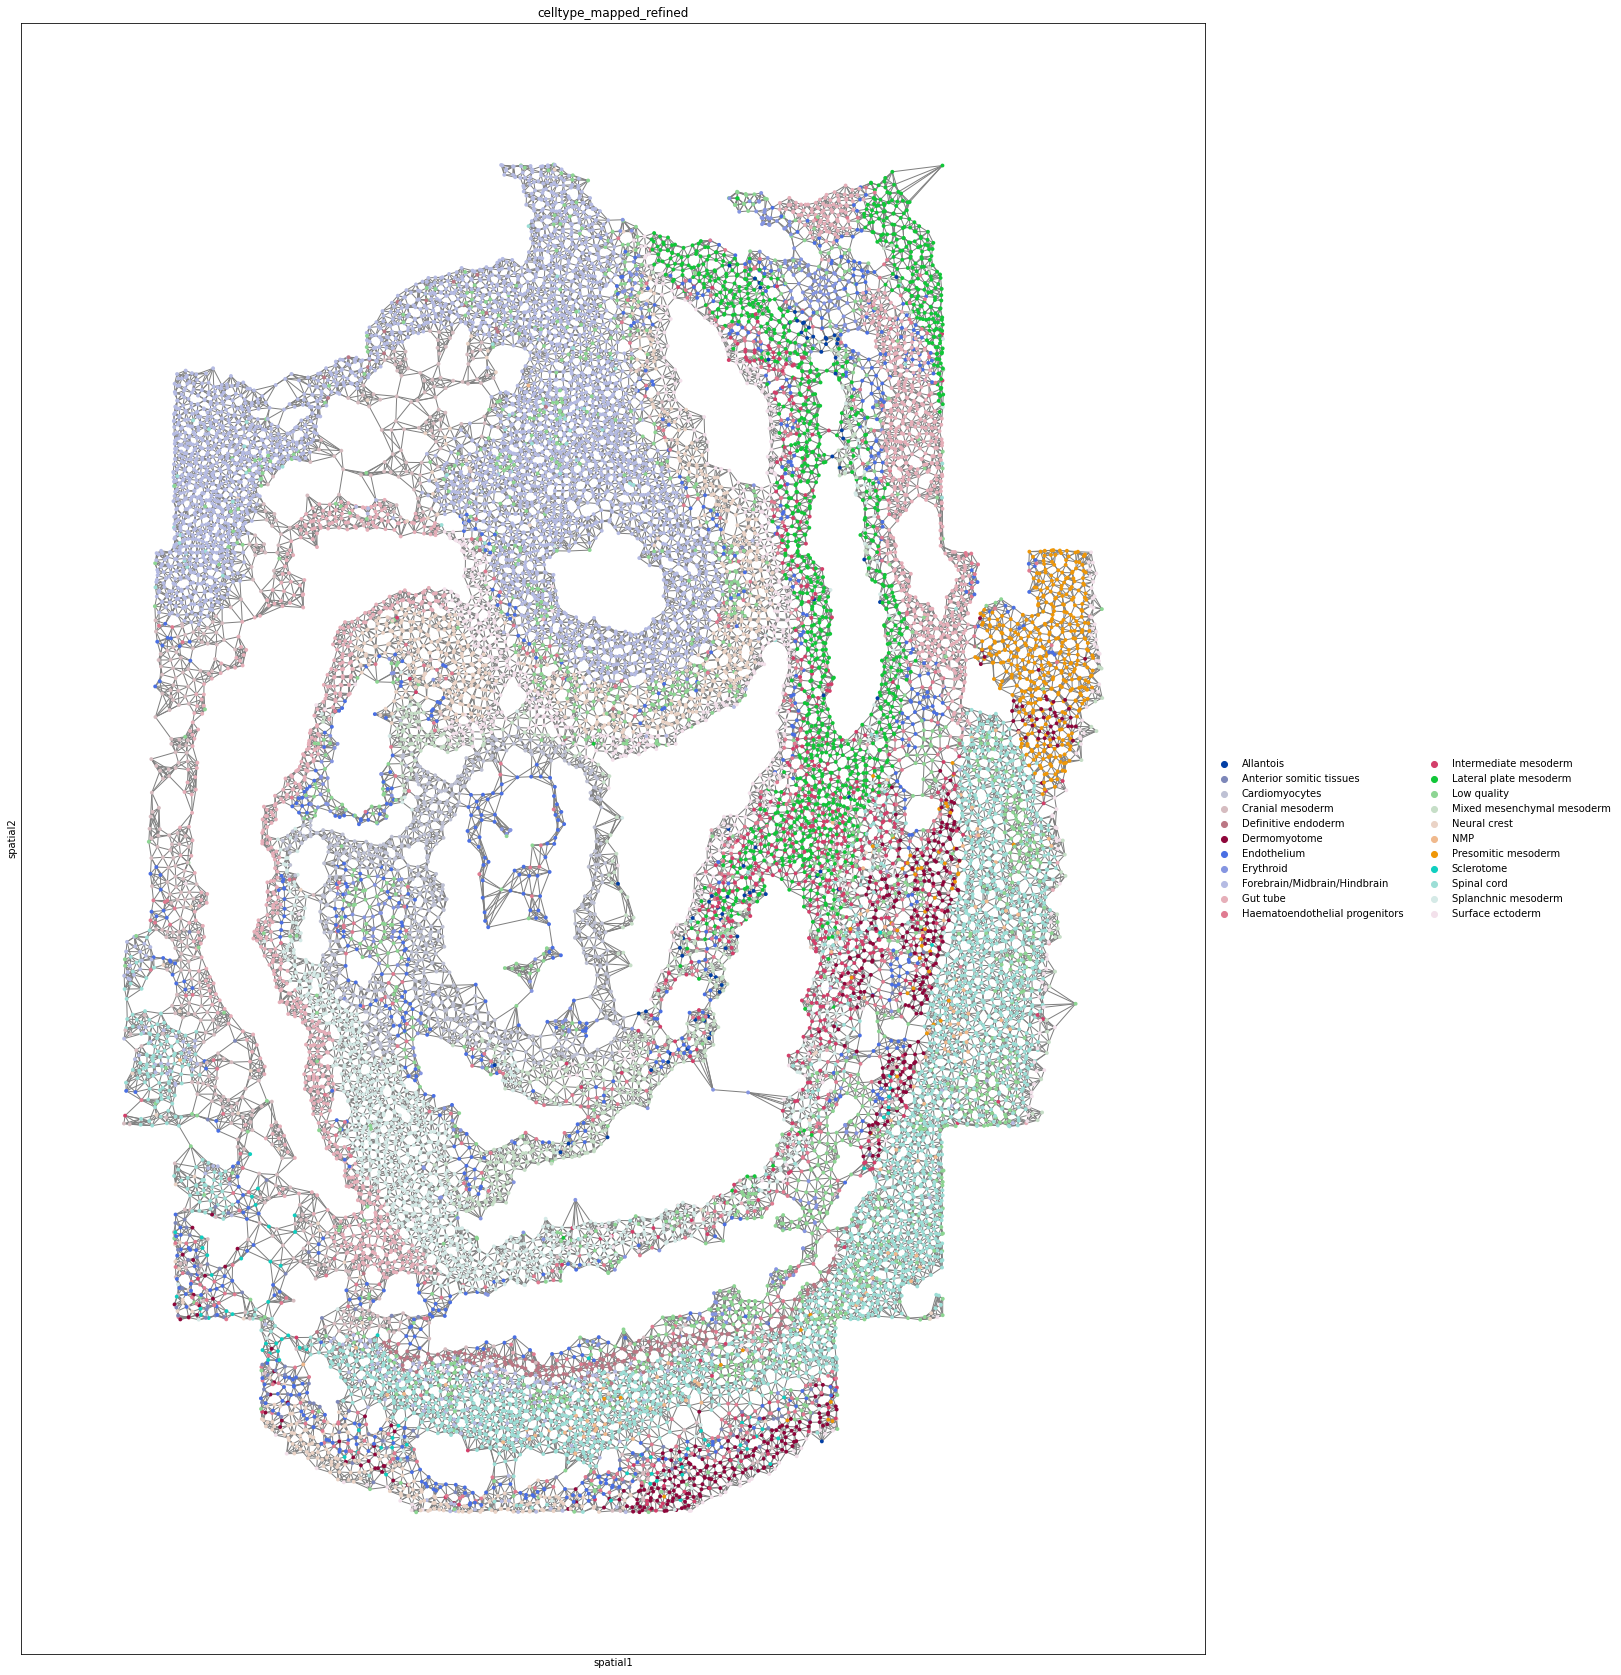

In [20]:
import matplotlib.pyplot as plt

sq.gr.spatial_neighbors(adata, n_neighs=6 , coord_type='generic')

plt.rcParams["figure.figsize"] = (30, 30)

sc.pl.spatial(
    adata,
    color="celltype_mapped_refined",
    neighbors_key="spatial_neighbors",
    spot_size=0.1,
    size=0.2,
    edges=True,
    edges_width=1,
    img_key=None,
    show=True
)